평가기준
- CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴
- 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점을 서술
- 기본 Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석

할일
- base 모델, 기본 aug적용, 기본 + cutmix, 기본 + mixup 모델 생성
- 시각화를 통해 성능 비교
- 결과 분석

In [1]:
# 라이브러리
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

tf.config.list_physical_devices('GPU')

2024-07-03 07:42:05.317889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-03 07:42:05.436540: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-03 07:42:30.823321: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2024-07-03 07:42:30.850524: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-03 07:42:30.850560: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
# 상수 선언


In [34]:
# 사용할 함수들 로드
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    # print('image_size_x : ', image_size_x)
    # print('image_size_y : ', image_size_y)
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    # 클립 박스의 너비(width)와 높이(height)를 랜덤하게 선택
    # tf.math.sqrt(1 - tf.random.uniform([], 0, 1))는 넓이와 높이가 큰 박스보다 작은 박스가 더 자주 생성되도록 하기 위해 사용
    # tf.random.uniform([], 0, 1): 0과 1 사이의 랜덤한 스칼라 값을 생성합니다.
    # tf.random.uniform([3], 0, 1): 0과 1 사이의 랜덤한 값 3개로 이루어진 1차원 텐서를 생성합니다.
    # tf.random.uniform([2, 3], 0, 1): 0과 1 사이의 랜덤한 값으로 이루어진 2 x 3 크기의 텐서를 생성합니다
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    print('width : ', width)
    print('height : ', height)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    # 겹치는 영역을 먼저 만듦
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1) 
    # 위 + 겹치는 영역 + 아래로 합침
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120, image_a=None):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    # 만약 라벨이 스칼라면(정수형 벡터라면) 원-핫 인코딩으로 변경해줌
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        # 배치 내 이미지 순서대로 선택
        image_a = image[i]
        label_a = label[i]
        # 배치 내 다른 이미지 랜덤하게 선택
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        # 작업
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, image_a=image_a))

    # 배치 사이즈만큼 쌓고, shape 맞춰서 반환
    # mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    # mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    mixed_imgs = tf.stack(mixed_imgs)
    mixed_labels = tf.stack(mixed_labels)
    return mixed_imgs, mixed_labels

def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    
    if is_test or (not is_test and not with_cutmix and not with_mixup):  #????????????????????? to-do
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.cache().shuffle(buffer_size=1000).batch(batch_size).repeat()
        # ds = ds.cache().shuffle(buffer_size=1000).repeat()
        # ds = ds.repeat()
        # ds = ds.shuffle(500)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [35]:
# 데이터 불러오기
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [24]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))
# 클래스 수
print(ds_info.features["label"].num_classes)
# 클래스 이름
print(ds_info.features["label"].names)

print(ds_info.splits['train'].num_examples)
print(int(ds_info.splits['train'].num_examples/16))
print(int(ds_info.splits['test'].num_examples/16))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
    }),
})
tf.Tensor(12000, shape=(), dtype=int64)
tf.Tensor(8580, shape=(), dtype=int64)
120
['n02085620-chihuahua', 'n02085782-japanese_spaniel', 'n02085936-maltese_dog', 'n02086079-pekinese', 'n02086240-shih-tzu', 'n02086646-blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-rhodesian_ridgeback', 'n02088094-afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-walker_hound', 'n02089973-english_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-irish_wolfhound', 'n02091032-italian_greyhound', 'n02091134-whippet', 'n02091244-ibizan_hound', 'n02091467-norwegian_elkhound', 'n02091635-otterho

In [36]:
# 학습에 사용할 상수 정의
batch_size = 8
learning_rate = 0.01
checkpoint_filepath_template  = './models/{model_name}_{EPOCH}_no_repeat.keras'
log_filepath_template = './history/{model_name}_{EPOCH}_no_repeat_train_log.csv'
# log_filepath = './history/no_repeat_train_log.csv'

# num_classes
num_classes = ds_info.features["label"].num_classes 

# steps_per_epoch와 validation_steps 계산
steps_per_epoch = int(ds_info.splits['train'].num_examples / batch_size)
validation_steps = int(ds_info.splits['test'].num_examples / batch_size)

In [37]:
# 데이터 증강 적용
ds_train_no_aug = apply_normalize_on_dataset(ds_train, batch_size=batch_size)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True, batch_size=batch_size)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True, batch_size=batch_size)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True, batch_size=batch_size)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
ds_test = ds_test.cache().batch(batch_size).repeat()

width :  Tensor("Cast_3:0", shape=(), dtype=int32)
height :  Tensor("Cast_4:0", shape=(), dtype=int32)
width :  Tensor("Cast_9:0", shape=(), dtype=int32)
height :  Tensor("Cast_10:0", shape=(), dtype=int32)
width :  Tensor("Cast_15:0", shape=(), dtype=int32)
height :  Tensor("Cast_16:0", shape=(), dtype=int32)
width :  Tensor("Cast_21:0", shape=(), dtype=int32)
height :  Tensor("Cast_22:0", shape=(), dtype=int32)
width :  Tensor("Cast_27:0", shape=(), dtype=int32)
height :  Tensor("Cast_28:0", shape=(), dtype=int32)
width :  Tensor("Cast_33:0", shape=(), dtype=int32)
height :  Tensor("Cast_34:0", shape=(), dtype=int32)
width :  Tensor("Cast_39:0", shape=(), dtype=int32)
height :  Tensor("Cast_40:0", shape=(), dtype=int32)
width :  Tensor("Cast_45:0", shape=(), dtype=int32)
height :  Tensor("Cast_46:0", shape=(), dtype=int32)
width :  Tensor("Cast_51:0", shape=(), dtype=int32)
height :  Tensor("Cast_52:0", shape=(), dtype=int32)
width :  Tensor("Cast_57:0", shape=(), dtype=int32)
height

In [38]:
# 모델 정의

# 모델 이름 리스트
# model_names = ['resnet50', 'aug_resnet50', 'cutmix_resnet50', 'mixup_resnet50']
# models = {}

# # 모델 생성 반복문
# for name in model_names:
#     model = keras.models.Sequential([
#         keras.applications.resnet.ResNet50(
#             include_top=False,
#             weights='imagenet',
#             input_shape=(224, 224, 3),
#             pooling='avg',
#         ),
#         keras.layers.Dense(num_classes, activation='softmax')
#     ])
#     models[name] = model
def get_trained_resnet50(input_shape=(224,224,3), num_classes=num_classes):
    model = keras.models.Sequential([
                keras.applications.resnet.ResNet50(
                    include_top=False,
                    weights="imagenet",
                    input_shape=input_shape,
                    pooling="avg",
                    ),
                keras.layers.Dense(num_classes, activation="softmax")
                ])
    return model

resnet50 = get_trained_resnet50()
aug_resnet50 = get_trained_resnet50()
cutmix_resnet50 = get_trained_resnet50()
mixup_resnet50 = get_trained_resnet50()

In [39]:
def train_model(model, name, ds_train, ds_test=ds_test, ds_info=ds_info, EPOCH=20):
    # ModelCheckpoint 콜백 설정
    checkpoint_filepath = checkpoint_filepath_template .format(model_name=name, EPOCH=EPOCH)
    checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',  # 검증 정확도를 모니터링
        save_best_only=True,  # 검증 정확도가 가장 높은 모델 저장
        mode='max',  # 검증 정확도가 최대일 때 저장
        save_weights_only=False,  # 전체 모델 저장
        verbose=1  # 저장 여부를 출력
    )

    # CSVLogger 콜백 설정
    log_filepath = log_filepath_template.format(model_name=name, EPOCH=EPOCH)
    csv_logger = CSVLogger(log_filepath, append=False)

    # compile model
    model.compile(loss="categorical_crossentropy",
                  optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                  metrics=["accuracy"],)
    
    # train model
    history = model.fit(ds_train,
                        steps_per_epoch=int(ds_info.splits["train"].num_examples/batch_size),
                        validation_steps=int(ds_info.splits["test"].num_examples/batch_size),
                        epochs=EPOCH,
                        validation_data=ds_test,
                        callbacks=[checkpoint_callback, csv_logger],
                        verbose=1,
                        # use_multiprocessing=True,
                        )
    
    return history

# 에폭 수, 여기서 조절하는게 편함 
EPOCH = 20
history_dict = dict()

# augmentation style option
NONE = 0
BASIC = 1
CUTMIX = 2
MIXUP = 3

# history_dict[NONE] = train_model(resnet50, 'resnet50', ds_train_no_aug, ds_test, ds_info, EPOCH)
# history_dict[BASIC] = train_model(aug_resnet50, 'aug_resnet50', ds_train_aug, ds_test, ds_info, EPOCH)
history_dict[CUTMIX] = train_model(cutmix_resnet50, 'cutmix_resnet50', ds_train_aug_cutmix, ds_test, ds_info, EPOCH)
history_dict[MIXUP] = train_model(mixup_resnet50, 'mixup_resnet50', ds_train_aug_mixup, ds_test, ds_info, EPOCH)

    # steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, 
    # 혹은 repeat(), shuffle() 등을 사용하면 발생 
    # 사용시 아래 에러 발생
    # 차트를 뽑아보면, validation 쪽에서 발생한 에러임 train 12000개, val 8500개 인 것이 영향이 있을까? 
    # 텐서플로우 특정 버전의 버그라는 듯 or repeat(), shuffle() 쪽 에러라는 얘기도 있음. 공식홈에 문제가 제기되어있으나 해결되지 않음 
    # W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	# [[{{node IteratorGetNext}}]]
	#  [[IteratorGetNext/_2]]
    # /usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
    #   self.gen.throw(typ, value, traceback)


Epoch 1/20


ValueError: Input 0 of layer "resnet50" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 16, None, 224, 3)

In [ ]:
# # 학습
# model_names = ['resnet50', 'aug_resnet50', 'cutmix_resnet50', 'mixup_resnet50']
# # 에폭 수, 여기서 조절하는게 편함 
# EPOCH = 20

# # 모델 정의 및 학습
# for name in model_names:
#     # ModelCheckpoint 콜백 설정
#     checkpoint_filepath = checkpoint_filepath_template .format(model_name=name, EPOCH=EPOCH)
#     checkpoint_callback = ModelCheckpoint(
#         filepath=checkpoint_filepath,
#         monitor='val_loss',  # 검증 정확도를 모니터링
#         save_best_only=True,  # 검증 정확도가 가장 높은 모델 저장
#         mode='max',  # 검증 정확도가 최대일 때 저장
#         save_weights_only=False,  # 전체 모델 저장
#         verbose=1  # 저장 여부를 출력
#     )

#     # CSVLogger 콜백 설정
#     log_filepath = log_filepath_template.format(model_name=name, EPOCH=EPOCH)
#     csv_logger = CSVLogger(log_filepath, append=False)
#     # csv_logger = CustomCSVLogger(log_filepath, model_name=name, append=True)

#     # 모델 컴파일
#     model.compile(
#         loss='categorical_crossentropy',
#         optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, clipnorm=1.),
#         metrics=['accuracy']
#     )

#     # 학습 데이터셋 선택
#     if name == 'resnet50':
#         dataset = ds_train_no_aug
#     elif name == 'aug_resnet50':
#         dataset = ds_train_aug
#     elif name == 'cutmix_resnet50':
#         dataset = ds_train_aug_cutmix
#     elif name == 'mixup_resnet50':
#         dataset = ds_train_aug_mixup

#     # 모델 학습
#     history = model.fit(
#         dataset,
#         steps_per_epoch=steps_per_epoch, 
#         validation_steps=validation_steps,
#         epochs=EPOCH,
#         validation_data=ds_test,
#         callbacks=[checkpoint_callback, csv_logger],
#         verbose=1
#     )

#     # steps_per_epoch=steps_per_epoch, validation_steps=validation_steps, 
#     # 사용시 아래 에러 발생
#     # 텐서플로우 특정 버전의 버그라는 듯 or VRAM이 부족할때 나오는 현상이라는 얘기도 있음 
#     # W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
# 	# [[{{node IteratorGetNext}}]]
# 	#  [[IteratorGetNext/_2]]
#     # /usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
#     #   self.gen.throw(typ, value, traceback)

Epoch 1/50


I0000 00:00:1719965413.543870   58824 service.cc:145] XLA service 0x7fd560002530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719965413.543912   58824 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-07-03 00:10:14.447322: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-03 00:10:17.138647: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906


  1/750 ━━━━━━━━━━━━━━━━━━━━ 6:10:29 30s/step - accuracy: 0.0000e+00 - loss: 5.7707

I0000 00:00:1719965432.869464   58824 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.0112 - loss: 5.1651
Epoch 1: val_loss improved from -inf to 5.64658, saving model to ./models/resnet50_50_no_repeat.keras
750/750 ━━━━━━━━━━━━━━━━━━━━ 94s 86ms/step - accuracy: 0.0112 - loss: 5.1650 - val_accuracy: 0.0105 - val_loss: 5.6466
Epoch 2/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0285 - loss: 4.7619
Epoch 2: val_loss did not improve from 5.64658
750/750 ━━━━━━━━━━━━━━━━━━━━ 60s 79ms/step - accuracy: 0.0285 - loss: 4.7618 - val_accuracy: 0.0516 - val_loss: 4.5364
Epoch 3/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.0711 - loss: 4.3609
Epoch 3: val_loss did not improve from 5.64658
750/750 ━━━━━━━━━━━━━━━━━━━━ 60s 80ms/step - accuracy: 0.0711 - loss: 4.3608 - val_accuracy: 0.1094 - val_loss: 4.1366
Epoch 4/50
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1477 - loss: 3.9681
Epoch 4: val_loss did not improve from 5.64658
750/750 ━━━━━━━━━━━━━━━━━━━━ 59s 79ms/step - accuracy: 0.1477 -

# history 시각화

In [ ]:
# CSV 파일 경로
common_path = '_20_no_repeat_train_log.csv'
log_filepaths = {
    'resnet50': f'./history/resnet50{common_path}',
    'aug_resnet50': f'./history/aug_resnet50{common_path}',
    'cutmix_resnet50': f'./history/cutmix_resnet50{common_path}',
    'mixup_resnet50': f'./history/mixup_resnet50{common_path}'
}

# 로그 파일을 데이터프레임으로 불러오기
log_dfs = {name: pd.read_csv(filepath) for name, filepath in log_filepaths.items()}

# 특정 에포크 이상
min_epoch = 10
filtered_log_dfs = {name: df[df['epoch'] >= min_epoch] for name, df in log_dfs.items()}

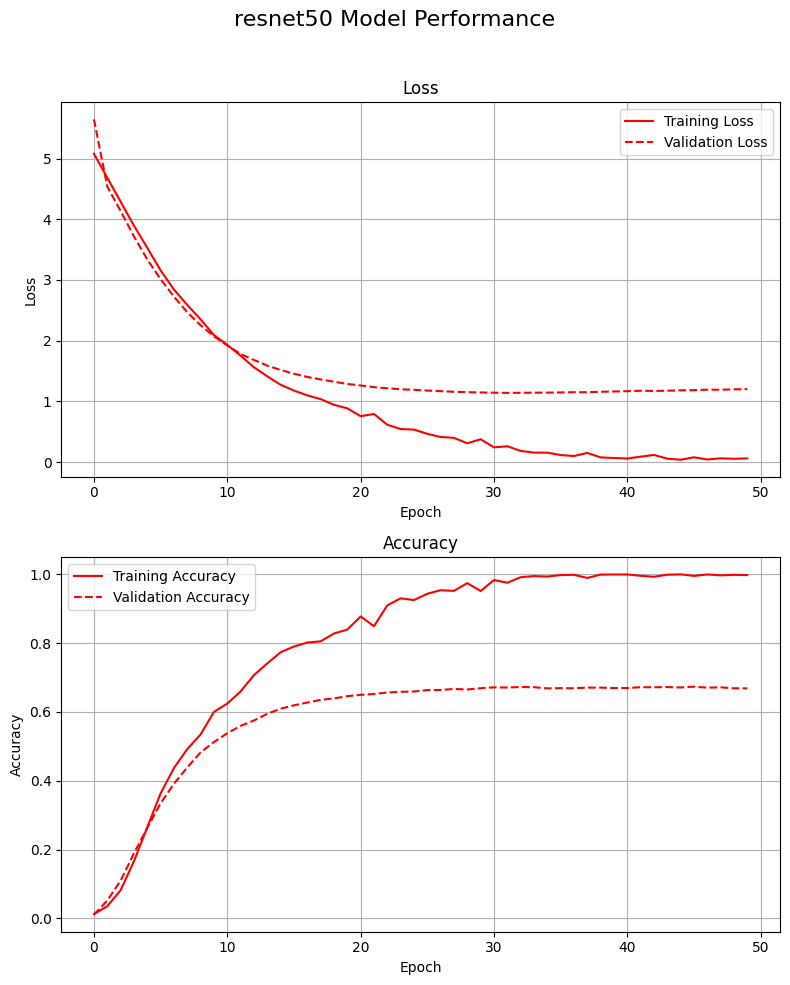

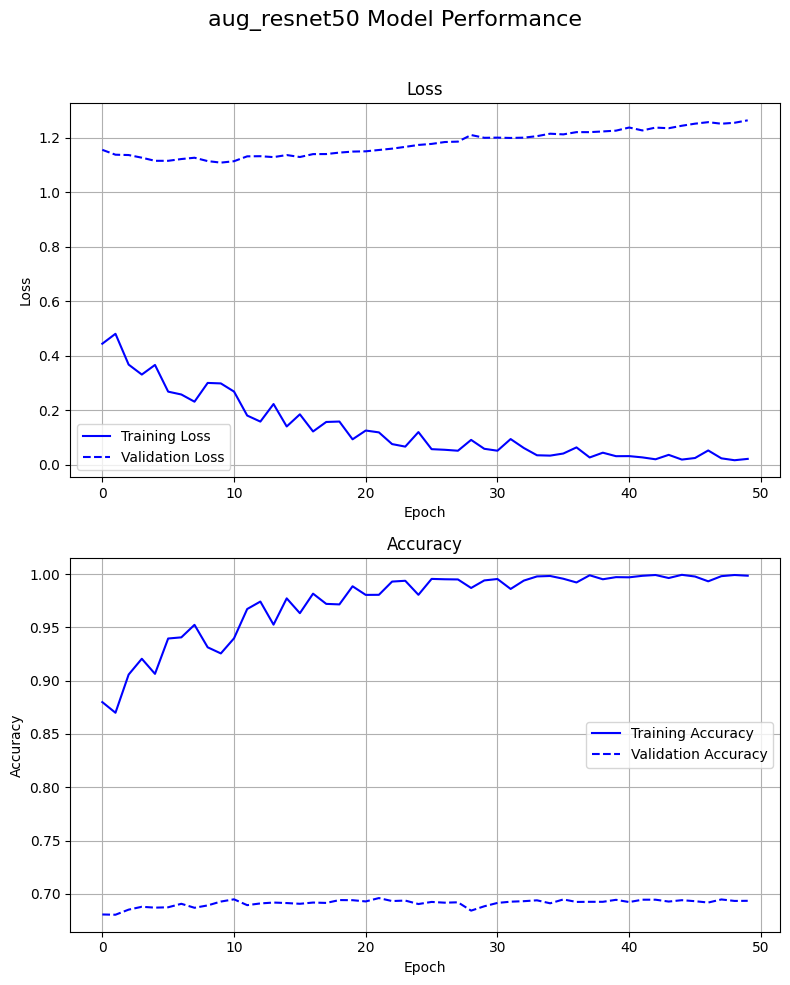

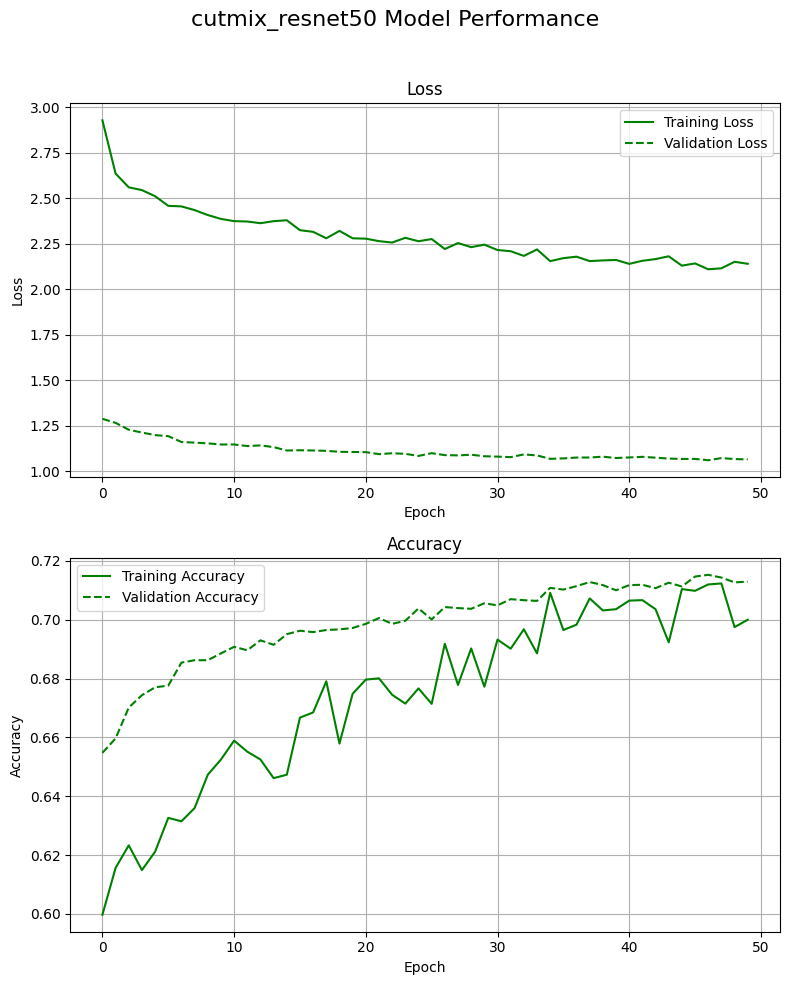

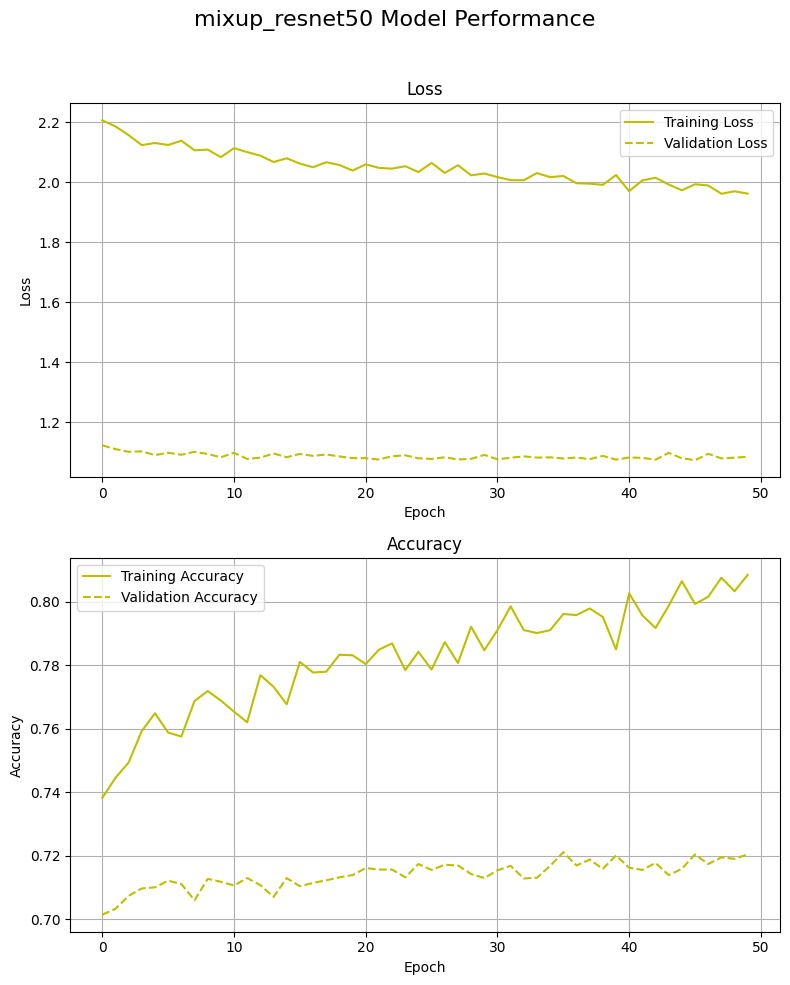

In [ ]:
# 로그 파일을 데이터프레임으로 불러오기
log_dfs = {name: pd.read_csv(filepath) for name, filepath in log_filepaths.items()}

colors = ['r', 'b', 'g', 'y']
model_names = list(log_filepaths.keys())

# 모델별로 반복하여 플로팅
for color, name in zip(colors, model_names):
    df = log_dfs[name]
    epochs = df['epoch']

    fig, axes = plt.subplots(2, 1, figsize=(8, 10))
    fig.suptitle(f'{name} Model Performance', fontsize=16)

    # 손실 그래프
    axes[0].plot(epochs, df['loss'], color + '-', label='Training Loss')
    axes[0].plot(epochs, df['val_loss'], color + '--', label='Validation Loss')
    axes[0].set_title('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(loc='best')
    axes[0].grid(True)

    # 정확도 그래프
    axes[1].plot(epochs, df['accuracy'], color + '-', label='Training Accuracy')
    axes[1].plot(epochs, df['val_accuracy'], color + '--', label='Validation Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(loc='best')
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f'./history/{name}_50_no_repeat.png')
    plt.show()

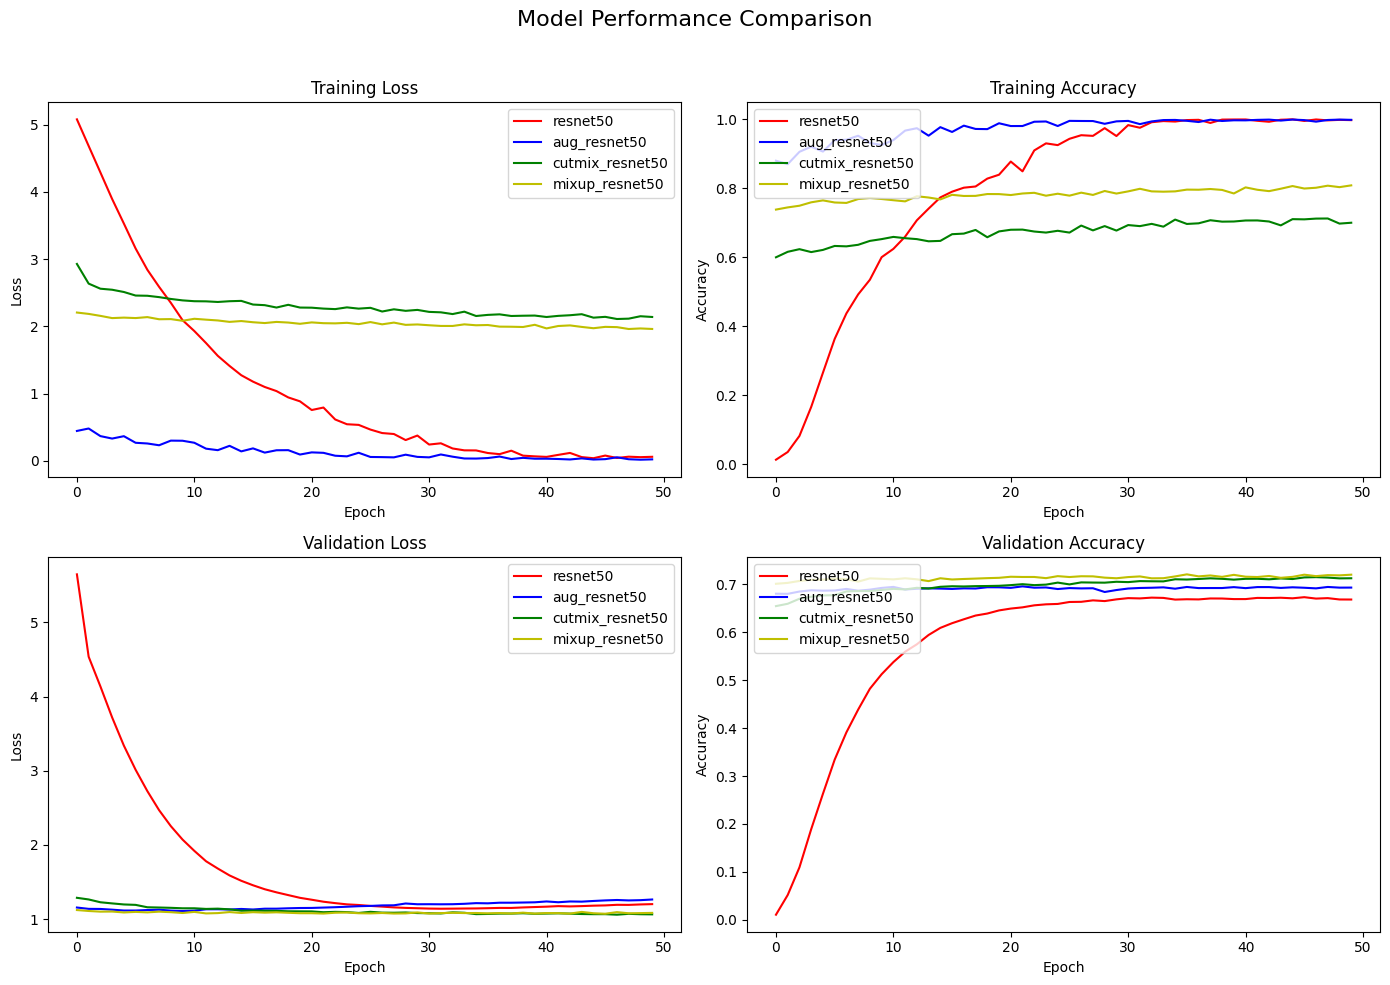

In [ ]:
# 그래프 설정
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

colors = ['r', 'b', 'g', 'y']
model_names = list(log_filepaths.keys())

# Loss 그래프
for color, name in zip(colors, model_names):
    axes[0, 0].plot(log_dfs[name]['epoch'], log_dfs[name]['loss'], color=color, label=name)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend(loc='upper right')

# Accuracy 그래프
for color, name in zip(colors, model_names):
    axes[0, 1].plot(log_dfs[name]['epoch'], log_dfs[name]['accuracy'], color=color, label=name)
axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend(loc='upper left')

# Validation Loss 그래프
for color, name in zip(colors, model_names):
    axes[1, 0].plot(log_dfs[name]['epoch'], log_dfs[name]['val_loss'], color=color, label=name)
axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend(loc='upper right')

# Validation Accuracy 그래프
for color, name in zip(colors, model_names):
    axes[1, 1].plot(log_dfs[name]['epoch'], log_dfs[name]['val_accuracy'], color=color, label=name)
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend(loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

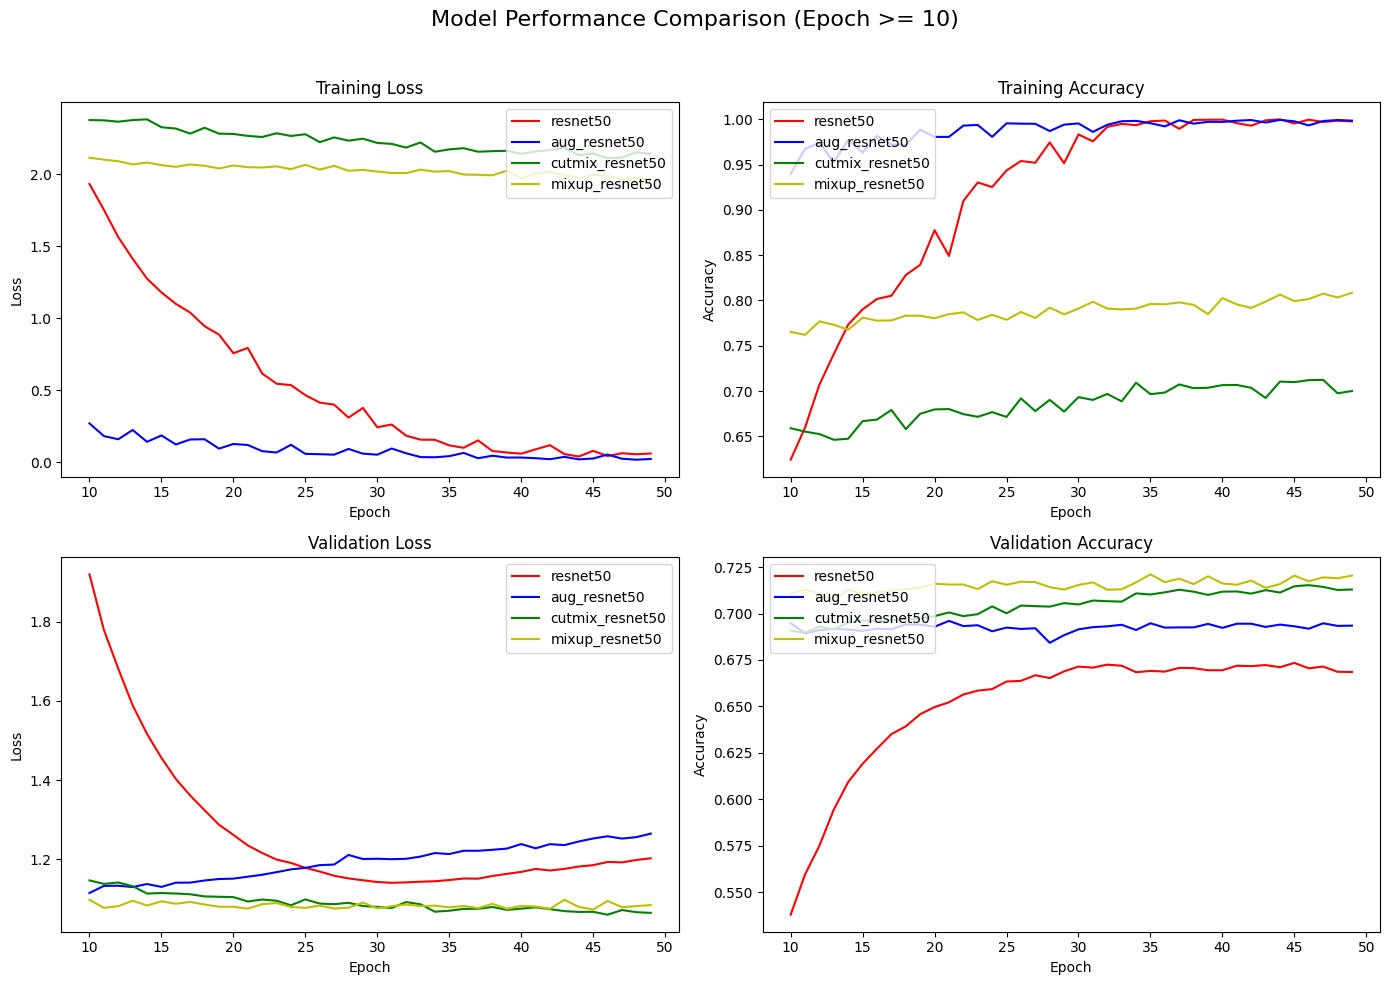

In [ ]:
# 그래프 설정
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison (Epoch >= {})'.format(min_epoch), fontsize=16)

colors = ['r', 'b', 'g', 'y']
model_names = list(log_filepaths.keys())

# Loss 그래프
for color, name in zip(colors, model_names):
    axes[0, 0].plot(filtered_log_dfs[name]['epoch'], filtered_log_dfs[name]['loss'], color=color, label=name)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend(loc='upper right')

# Accuracy 그래프
for color, name in zip(colors, model_names):
    axes[0, 1].plot(filtered_log_dfs[name]['epoch'], filtered_log_dfs[name]['accuracy'], color=color, label=name)
axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend(loc='upper left')

# Validation Loss 그래프
for color, name in zip(colors, model_names):
    axes[1, 0].plot(filtered_log_dfs[name]['epoch'], filtered_log_dfs[name]['val_loss'], color=color, label=name)
axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend(loc='upper right')

# Validation Accuracy 그래프
for color, name in zip(colors, model_names):
    axes[1, 1].plot(filtered_log_dfs[name]['epoch'], filtered_log_dfs[name]['val_accuracy'], color=color, label=name)
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend(loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

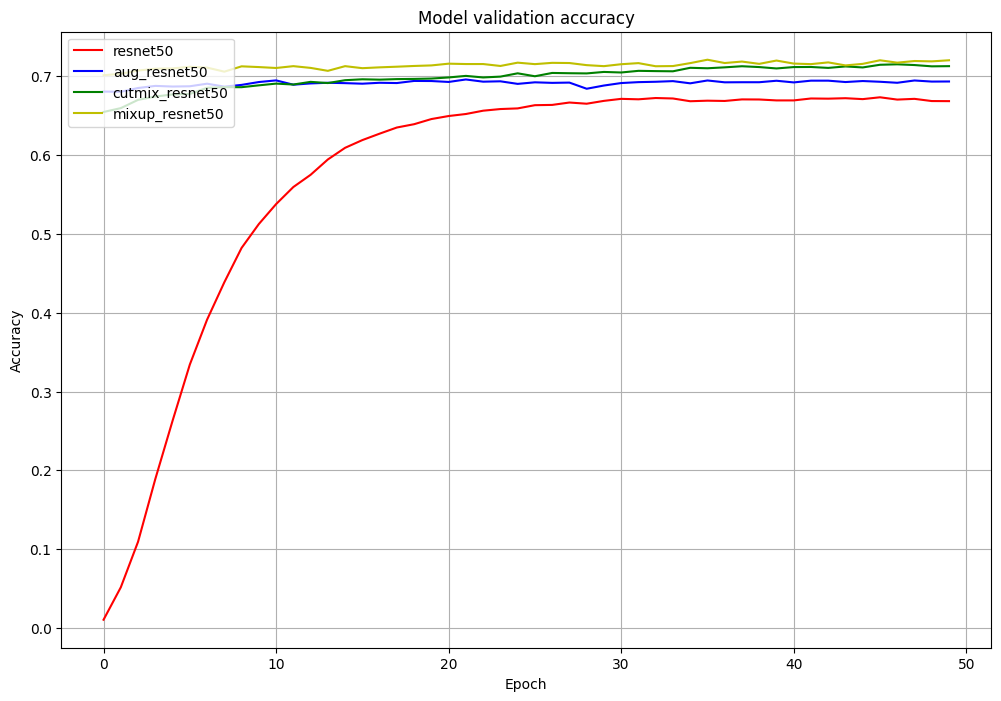

In [ ]:
# 모델별 검증 정확도 시각화
plt.figure(figsize=(12, 8))
colors = ['r', 'b', 'g', 'y']
for color, (name, df) in zip(colors, log_dfs.items()):
    plt.plot(df['epoch'], df['val_accuracy'], color=color, label=name)

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
log_dfs

{'resnet50':     epoch  accuracy      loss  val_accuracy  val_loss
 0       0  0.012583  5.080211      0.010490  5.646584
 1       1  0.034917  4.684295      0.051632  4.536444
 2       2  0.081583  4.290587      0.109441  4.136617
 3       3  0.165667  3.895312      0.189044  3.718054
 4       4  0.264917  3.529809      0.262937  3.338305
 5       5  0.363000  3.158781      0.334266  3.012780
 6       6  0.437000  2.842309      0.391259  2.725083
 7       7  0.492083  2.588133      0.438695  2.468220
 8       8  0.534667  2.350724      0.482284  2.253164
 9       9  0.600083  2.091829      0.512587  2.071734
 10     10  0.624167  1.930817      0.537879  1.920015
 11     11  0.659667  1.751668      0.559557  1.779947
 12     12  0.707083  1.561855      0.575058  1.681677
 13     13  0.740917  1.411769      0.594522  1.588907
 14     14  0.773417  1.273376      0.609324  1.516537
 15     15  0.790083  1.177821      0.619114  1.456127
 16     16  0.801667  1.098485      0.627273  1.40268

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 경로
log_filepaths = {
    'resnet50': '/path/to/save/resnet50_training_log.csv',
    'aug_resnet50': '/path/to/save/aug_resnet50_training_log.csv',
    'cutmix_resnet50': '/path/to/save/cutmix_resnet50_training_log.csv',
    'mixup_resnet50': '/path/to/save/mixup_resnet50_training_log.csv'
}

# 로그 파일을 데이터프레임으로 불러오기
log_dfs = {name: pd.read_csv(filepath) for name, filepath in log_filepaths.items()}

# 그래프 설정
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Model Performance Comparison', fontsize=16)

colors = ['r', 'b', 'g', 'y']
model_names = list(log_filepaths.keys())

# Loss 그래프
for color, name in zip(colors, model_names):
    axes[0, 0].plot(log_dfs[name]['epoch'], log_dfs[name]['loss'], color=color, label=name)
axes[0, 0].set_title('Training Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend(loc='upper right')

# Accuracy 그래프
for color, name in zip(colors, model_names):
    axes[0, 1].plot(log_dfs[name]['epoch'], log_dfs[name]['accuracy'], color=color, label=name)
axes[0, 1].set_title('Training Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend(loc='upper left')

# Validation Loss 그래프
for color, name in zip(colors, model_names):
    axes[1, 0].plot(log_dfs[name]['epoch'], log_dfs[name]['val_loss'], color=color, label=name)
axes[1, 0].set_title('Validation Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend(loc='upper right')

# Validation Accuracy 그래프
for color, name in zip(colors, model_names):
    axes[1, 1].plot(log_dfs[name]['epoch'], log_dfs[name]['val_accuracy'], color=color, label=name)
axes[1, 1].set_title('Validation Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend(loc='upper left')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/path/to/save/resnet50_training_log.csv'

In [ ]:
# plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
# plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
# plt.title('Model validation accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
# plt.show()

In [ ]:
# plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
# plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
# plt.title('Model validation accuracy')
# plt.ylabel('Accuracy')
# plt.xlabel('Epoch')
# plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
# plt.grid(True)
# plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
# #plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
# plt.show()